# Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier

# Obtain Data

In [4]:
df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scrub Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop columns not useful for modeling

In [6]:
df.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Fare'], inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,S
4,0,3,"Allen, Mr. William Henry",male,35.0,S


Create dummy columns for Pclass and categorical variables

In [7]:
df = pd.get_dummies(df, columns=['Pclass', 'Sex'], drop_first=False)
df.drop(columns=['Pclass_2', 'Sex_female'], inplace=True)
df.head()

,Survived,Name,Age,Embarked,Pclass_1,Pclass_3,Sex_male
0,0,"Braund, Mr. Owen Harris",22.0,S,0,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,C,1,0,0
2,1,"Heikkinen, Miss. Laina",26.0,S,0,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,S,1,0,0
4,0,"Allen, Mr. William Henry",35.0,S,0,1,1


Create dummy columns for Embarked variable, while mantaining Embarked np.nan values in the dummy columns

In [8]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False, dummy_na=True)
df.drop(columns=['Embarked_Q'], inplace=True)

def embarked_na(row):
    if row['Embarked_nan'] == 1:
        row['Embarked_S'] = np.nan
        row['Embarked_C'] = np.nan
        return row
    else:
        return row

df = df.apply(embarked_na, axis=1)
df.drop(columns='Embarked_nan', inplace=True)
df.head()

,Survived,Name,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
0,0,"Braund, Mr. Owen Harris",22.0,0,1,1,0.0,1.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,0,1.0,0.0
2,1,"Heikkinen, Miss. Laina",26.0,0,1,0,0.0,1.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,0,0.0,1.0
4,0,"Allen, Mr. William Henry",35.0,0,1,1,0.0,1.0


Create Title feature from Name

In [9]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df.drop(columns=['Name'], inplace=True)
df.head()

,Survived,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title
0,0,22.0,0,1,1,0.0,1.0,Mr
1,1,38.0,1,0,0,1.0,0.0,Mrs
2,1,26.0,0,1,0,0.0,1.0,Miss
3,1,35.0,1,0,0,0.0,1.0,Mrs
4,0,35.0,0,1,1,0.0,1.0,Mr


Merge all special titles into a single class

In [10]:
def special_title(row):
    if row['Title'] in ['Mr', 'Miss', 'Mrs', 'Master']:
        return row['Title']
    elif row['Title'] in ['Mlle', 'Ms']:
        return 'Miss'
    elif row['Sex_male'] == 0:
        return 'Mrs'
    else: 
        return 'Special'
df['Title'] = df.apply(special_title, axis=1)
df.head()

,Survived,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title
0,0,22.0,0,1,1,0.0,1.0,Mr
1,1,38.0,1,0,0,1.0,0.0,Mrs
2,1,26.0,0,1,0,0.0,1.0,Miss
3,1,35.0,1,0,0,0.0,1.0,Mrs
4,0,35.0,0,1,1,0.0,1.0,Mr


Create dummy variables for Title feature

In [11]:
df = pd.get_dummies(df, columns=['Title'], drop_first=False)
df.drop(columns=['Title_Special'], inplace=True)
df.head()

,Survived,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,22.0,0,1,1,0.0,1.0,0,0,1,0
1,1,38.0,1,0,0,1.0,0.0,0,0,0,1
2,1,26.0,0,1,0,0.0,1.0,0,1,0,0
3,1,35.0,1,0,0,0.0,1.0,0,0,0,1
4,0,35.0,0,1,1,0.0,1.0,0,0,1,0


Impute missing age values with knn imputer

In [12]:
impute_x = df.drop(columns=['Survived'])
impute_y = df['Survived']

impute_xtrain, impute_xtest, impute_ytrain, impute_ytest = train_test_split(impute_x, impute_y, 
                                                                            test_size=0.25, random_state=121)

impute_ss = StandardScaler()
impute_ss.fit(impute_xtrain)
impute_xtrain = pd.DataFrame(impute_ss.transform(impute_xtrain), columns=impute_xtrain.columns, 
                             index=impute_xtrain.index)
impute_x = pd.DataFrame(impute_ss.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

imputer = KNNImputer()
imputer.fit(impute_xtrain)
impute_x = pd.DataFrame(imputer.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

impute_x = pd.DataFrame(impute_ss.inverse_transform(impute_x), columns=impute_x.columns, index=impute_x.index)
df = pd.concat([impute_x, impute_y], axis=1)
df = df.round(4)
df.head()

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived
0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,38.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,26.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,35.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0


Drop all Title features except Special 

In [13]:
df['Title_Special'] = df[['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs']].apply(lambda x: 1-sum(x), axis=1)
df.drop(columns=['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs'], inplace=True)
df.head()

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Survived,Title_Special
0,22.0,0.0,1.0,1.0,0.0,1.0,0,0.0
1,38.0,1.0,0.0,0.0,1.0,0.0,1,0.0
2,26.0,0.0,1.0,0.0,0.0,1.0,1,0.0
3,35.0,1.0,0.0,0.0,0.0,1.0,1,0.0
4,35.0,0.0,1.0,1.0,0.0,1.0,0,0.0


Confirm data now scrubbed with df.info()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            891 non-null    float64
 1   Pclass_1       891 non-null    float64
 2   Pclass_3       891 non-null    float64
 3   Sex_male       891 non-null    float64
 4   Embarked_C     891 non-null    float64
 5   Embarked_S     891 non-null    float64
 6   Survived       891 non-null    int64  
 7   Title_Special  891 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 55.8 KB


# Explore Data

Find train set outliers with isolation forest

In [15]:
isf_x = df.drop(columns='Survived')
isf_y = df['Survived']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y, test_size=0.25, random_state=121)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.02)
isf_xtrain['Outlier'] = isf.fit_predict(isf_xtrain)
isf_xtrain[isf_xtrain['Outlier']==-1].round(1)

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Outlier
626,1.8,-0.5,-1.1,0.7,-0.5,-1.6,6.6,-1
829,2.2,1.8,-1.1,-1.4,0.5,-0.3,-0.2,-1
245,0.9,1.8,-1.1,0.7,-0.5,-1.6,6.6,-1
827,-2.1,-0.5,-1.1,0.7,2.1,-1.6,-0.2,-1
694,2.0,1.8,-1.1,0.7,-0.5,0.6,6.6,-1
632,0.1,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
249,1.6,-0.5,-1.1,0.7,-0.5,0.6,6.6,-1
647,1.7,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
599,1.3,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
745,2.7,1.8,-1.1,0.7,-0.5,0.6,6.6,-1


Find test set outliers with Isolation Forest

In [16]:
isf_xtest = pd.DataFrame(isf_ss.transform(isf_xtest), columns=isf_xtest.columns, index=isf_xtest.index)
isf_xtest['Outlier'] = isf.predict(isf_xtest)
isf_xtest[isf_xtest['Outlier']==-1].round(1)

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Outlier
30,0.6,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
317,1.6,-0.5,-1.1,0.7,-0.5,0.6,6.6,-1


Replace all Age values > 4 standard deviations from the mean with the 4 standard deviation value

In [17]:
replace_x = df.drop(columns='Survived')
replace_y = df['Survived']

replace_xtrain, replace_xtest, replace_ytrain, replace_ytest = train_test_split(replace_x, replace_y, 
                                                                            test_size=0.25, random_state=121)

replace_ss = StandardScaler()
replace_ss.fit(replace_xtrain)
replace_xtrain = pd.DataFrame(replace_ss.transform(replace_xtrain), columns=replace_xtrain.columns, 
                             index=replace_xtrain.index)
replace_x = pd.DataFrame(replace_ss.transform(replace_x), columns=replace_x.columns, 
                             index=replace_x.index)

def replace_val(row):
    if row > 4:
        return 4
    if row < -4:
        return -4
    else:
        return row

replace_x['Age'] = replace_x['Age'].apply(replace_val)
replace_x = pd.DataFrame(replace_ss.inverse_transform(replace_x), columns=replace_x.columns, index=replace_x.index)
df = pd.concat([replace_x, replace_y], axis=1)
df = df.round(4)
df.head()

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Survived
0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0
1,38.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,26.0,0.0,1.0,0.0,0.0,1.0,0.0,1
3,35.0,1.0,0.0,0.0,0.0,1.0,0.0,1
4,35.0,0.0,1.0,1.0,0.0,1.0,0.0,0


Calculate descriptive statistics for each feature

In [18]:
df.describe().iloc[:, 0:10]

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,30.689493,0.242424,0.551066,0.647587,0.189450,0.724130,0.022447,0.383838
std,14.261958,0.428790,0.497665,0.477990,0.391397,0.446599,0.148214,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,40.400000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot class distribution for Survived dependent variable

[Text(0, 0, '0 (Non-Survivor)'), Text(1, 0, '1 (Survivor)')]

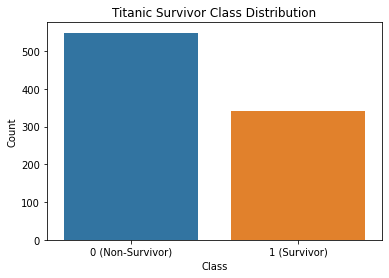

In [19]:
fig, ax = plt.subplots()
sns.countplot(x='Survived', data=df, ax=ax)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Titanic Survivor Class Distribution')
ax.set_xticklabels(['0 (Non-Survivor)', '1 (Survivor)'])

Plot distribution for each feature in Titanic dataset

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

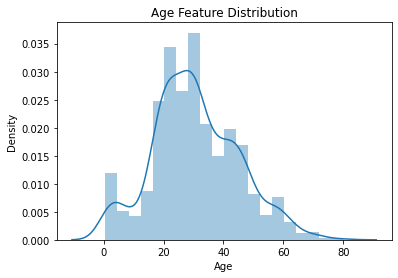

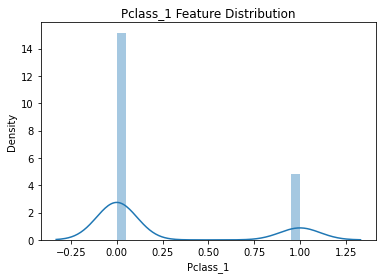

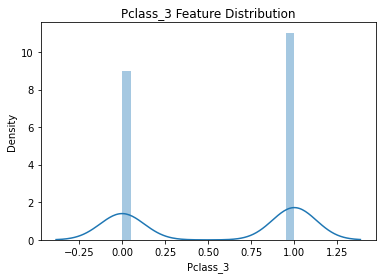

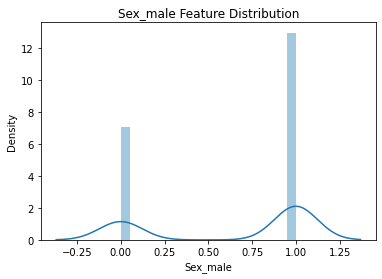

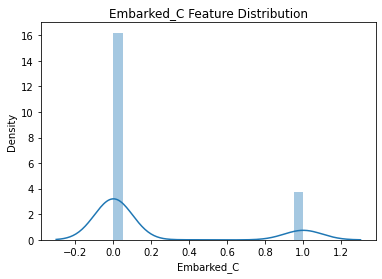

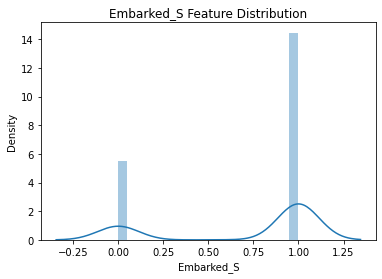

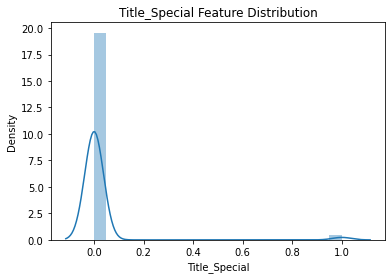

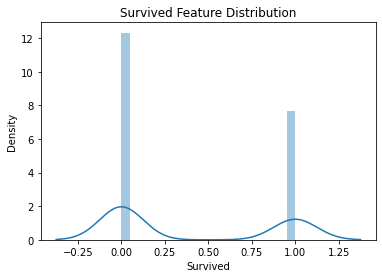

In [20]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=20)
    ax.set_title(f'{feat} Feature Distribution')

Calculate VIF to confirm that there are no correlated features

In [21]:
vif_x = df.drop(columns=['Survived'])
vif_y = df['Survived']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.25, random_state=121)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,25.5
1,Embarked_C,2.9
2,Embarked_S,2.8
3,Pclass_1,1.9
4,Pclass_3,1.8
5,Age,1.3
6,Sex_male,1.2
7,Title_Special,1.1


# Model Data

Create x and y variables

In [22]:
x = df.drop(columns=['Survived'])
y = df['Survived']

Perform train test split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=121)

Standard scale data

In [24]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build and evaluate dummy classifier

In [25]:
dc = DummyClassifier(strategy='stratified')
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier: 
Train f1 Score:  0.38582677165354334
Train Accuracy Score: 0.5329341317365269
Test f1 Score:  0.4333333333333333
Test Accuracy Score: 0.5426008968609866


Gridsearch Logistic Regression Model

In [26]:
lr_gs_dict = {'C': [x/10000 for x in range(150, 201)]}
lr_gs_model = LogisticRegression(random_state=204)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

Fitting 5 folds for each of 51 candidates, totalling 255 fits
LogisticRegression(C=0.0179, random_state=204)
0.8038379530916844


Build and evaluate top performing gridsearch logistic regression model

In [27]:
lr = LogisticRegression(C=.0179, random_state=204)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression: 
Train f1 Score:  0.7322175732217574
Train Accuracy Score: 0.8083832335329342
Test f1 Score:  0.7100591715976332
Test Accuracy Score: 0.7802690582959642


Gridsearch SVC model

In [29]:
svc_gs_dict = {'C': [x/10 for x in range(100, 201)],
               'gamma': [x/1000 for x in range(50, 151)]}
svc_gs_model = SVC(random_state=491)
svc_gs = GridSearchCV(svc_gs_model, svc_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
svc_gs.fit(x_train, y_train)

print(svc_gs.best_estimator_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 10201 candidates, totalling 51005 fits
SVC(C=12.7, gamma=0.081, random_state=491)
0.8218381775333856


Fit and evaluate top performing SVC model

In [30]:
svc = SVC(C=12.7, gamma=.081, random_state=491, probability=True)
svc.fit(x_train, y_train)
y_train_pred_svc = svc.predict(x_train)
y_test_pred_svc = svc.predict(x_test)
print('SVC: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_svc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_svc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_svc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_svc))

SVC: 
Train f1 Score:  0.7431192660550459
Train Accuracy Score: 0.8323353293413174
Test f1 Score:  0.7402597402597403
Test Accuracy Score: 0.820627802690583


Gridsearch adaboost model

In [31]:
ab_gs_dict = {'learning_rate': [x/1000 for x in range(1500, 2001)],
             'n_estimators': [x*10 for x in range(5, 21)]}
ab_gs_model = AdaBoostClassifier(random_state=19)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)

print(ab_gs.best_estimator_)
print(ab_gs.best_score_)

Fitting 5 folds for each of 8016 candidates, totalling 40080 fits
AdaBoostClassifier(learning_rate=1.856, n_estimators=60, random_state=19)
0.8157894736842104


Fit and evaluate top performing adaboost model

In [32]:
ab = AdaBoostClassifier(learning_rate=1.856, n_estimators=60, random_state=19)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_ab))

Adaboost: 
Train f1 Score:  0.773076923076923
Train Accuracy Score: 0.8233532934131736
Test f1 Score:  0.7208121827411168
Test Accuracy Score: 0.7533632286995515


Gridsearch random forest model

In [59]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [x/7 for x in range(1, 8)],
              'max_leaf_nodes': [x for x in range(20, 31)],
              'max_samples': [x/1000 for x in range(100, 201)]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 15554 candidates, totalling 77770 fits
RandomForestClassifier(max_features=0.7142857142857143, max_leaf_nodes=25,
                       max_samples=0.158, n_jobs=-1, random_state=712)
0.8338233643811019


In [ ]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [.1, .2, .3],
              'max_samples': [.065, .0675, .07, .0725, .075],
              'min_impurity_decrease': [.001, .002, .003, .004, .005, .006, .007]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fit and evaluate top performing random forest model

In [58]:
rf = RandomForestClassifier(criterion='gini', max_features=5/7, max_leaf_nodes=25, max_samples=0.158, n_jobs=-1,
                       random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.7957894736842104
Train Accuracy Score: 0.8547904191616766
Test f1 Score:  0.7058823529411764
Test Accuracy Score: 0.7757847533632287


In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_features=0.1, max_samples=0.07,
                       min_impurity_decrease=0.004, n_jobs=-1, random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Fit and evaluate voting classifier

In [ ]:
vc = VotingClassifier([('svc', svc), ('rf', rf)], voting='soft', weights=[1, 0])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_vc))

In [ ]:
joint_df = df[['Fare', 'Survived']]
joint_df['Fare'] = joint_df['Fare'].round(-1)
joint_df = joint_df.groupby('Fare').mean()[['Survived']].reset_index()
sns.jointplot(x='Fare', y='Survived', data=joint_df)

In [ ]:
df.columns

In [ ]:
df.groupby('Embarked_C').mean()['Survived']

In [ ]:
df.groupby('Embarked_Q').mean()['Survived']

In [ ]:
df.groupby('Embarked_S').mean()['Survived']

In [ ]:
pd.DataFrame(lr.coef_, columns=x.columns).T.reset_index().sort_values(by=0)

In [ ]:
df.corr()['Fare']

In [ ]:
df.groupby('Pclass').mean()['Survived']

In [ ]:
df[df['Sex']=='male'].groupby('Pclass').mean()['Survived']

In [ ]:
df[df['Sex']=='female'].groupby('Pclass').mean()['Survived']

In [ ]:
df[df['Pclass']==1].groupby('Sex').count()['Survived']

In [ ]:
df[df['Pclass']==2].groupby('Sex').count()['Survived']

In [ ]:
df[df['Pclass']==3].groupby('Sex').count()['Survived']

In [ ]:
df[(df['Sex']=='female')&(df['Pclass']==3)].groupby('Parch').mean()['Survived']

In [ ]:
df[(df['Sex']=='male')&(df['Pclass']==1)].groupby('Parch').mean()['Survived']

In [ ]:
df.info()

In [ ]:
test_df = pd.read_csv('Data/train.csv')
test_df.head()

In [ ]:
test_df['Cabin'] = test_df['Cabin'].replace({np.nan: ' '})
test_df['Floor'] = test_df['Cabin'].apply(lambda x:x[0])
test_df.head(10)

In [ ]:
test_df['Floor'].value_counts()

In [ ]:
test_df.groupby('Floor').mean()['Survived']

In [ ]:
test_df[['Ticket','Pclass']].head(50)

In [ ]:
test_df[test_df['Sex']=='female'][['Name']]

In [ ]:
test_df[test_df['Sex']=='female'][['Name']].head(50)

In [ ]:
df[(df['Title_Miss']==0)&(df['Title_Mr']==0)&(df['Title_Mrs']==0)&(df['Title_Special']==0)].groupby('Pclass_3').mean()['Survived']

In [ ]:
df[(df['Age']>40)&(df['Pclass_1']==1)&(df['Sex_male']==1)].groupby('Title_Special').mean()['Survived']

In [ ]:
df.columns

In [13]:
df[(df['Sex']=='male')&(df['Pclass']==1)].groupby('Fare').count()['Survived'].sort_values(ascending=False).head(50)

Fare
26.5500     14
0.0000       5
30.5000      5
52.0000      5
35.5000      4
30.0000      4
26.2875      3
27.7208      3
29.7000      3
53.1000      3
79.2000      3
110.8833     2
90.0000      2
120.0000     2
77.2875      2
263.0000     2
76.7292      2
52.5542      2
512.3292     2
30.6958      2
31.0000      2
26.0000      2
247.5208     1
108.9000     1
27.7500      1
79.6500      1
81.8583      1
82.1708      1
83.4750      1
89.1042      1
26.3875      1
91.0792      1
106.4250     1
25.5875      1
227.5250     1
28.5000      1
113.2750     1
25.9250      1
133.6500     1
135.6333     1
151.5500     1
153.4625     1
211.5000     1
221.7792     1
78.8500      1
34.6542      1
35.0000      1
71.0000      1
34.0208      1
38.5000      1
Name: Survived, dtype: int64

Index(['Age', 'Pclass_1', 'Pclass_3', 'Embarked_C', 'Embarked_S', 'Title_Mr',
       'Survived', 'Title_Ms'],
      dtype='object')

In [69]:
bins = pd.cut(df[(df['Sex']=='female')&(df['Pclass']==3)]['Age'], [-1, 5, 10, 15, 20, 25, 30, 40, 100])

In [70]:
df[(df['Sex']=='female')&(df['Pclass']==3)].groupby(bins).mean()['Survived']

Age
(-1, 5]      0.733333
(5, 10]      0.000000
(10, 15]     0.625000
(15, 20]     0.470588
(20, 25]     0.500000
(25, 30]     0.500000
(30, 40]     0.428571
(40, 100]    0.111111
Name: Survived, dtype: float64

In [71]:
df[(df['Sex']=='female')&(df['Pclass']==3)].groupby(bins).count()['Survived']

Age
(-1, 5]      15
(5, 10]       7
(10, 15]      8
(15, 20]     17
(20, 25]     18
(25, 30]     14
(30, 40]     14
(40, 100]     9
Name: Survived, dtype: int64

In [133]:
df.columns

Index(['Age', 'Pclass_1', 'Pclass_3', 'Embarked_C', 'Embarked_S', 'Title_Mr',
       'Survived', 'Title_Ms'],
      dtype='object')

In [135]:
bins = pd.cut(df[(df['Title_Mr']==1)&(df['Pclass_1']==1)]['Age'], [-1, 25, 30, 36, 42, 48, 56, 100])

In [136]:
df[(df['Title_Mr']==1)&(df['Pclass_1']==1)].groupby(bins).mean()['Survived']

Age
(-1, 25]     0.500000
(25, 30]     0.500000
(30, 36]     0.642857
(36, 42]     0.416667
(42, 48]     0.277778
(48, 56]     0.166667
(56, 100]    0.214286
Name: Survived, dtype: float64

In [138]:
df[(df['Title_Mr']==1)&(df['Pclass_1']==1)].groupby(bins).count()['Survived']

Age
(-1, 25]     14
(25, 30]     12
(30, 36]     14
(36, 42]     12
(42, 48]     18
(48, 56]     12
(56, 100]    28
Name: Survived, dtype: int64

In [140]:
bins = pd.cut(df[(df['Title_Mr']==0)&(df['Title_Ms']==0)&(df['Pclass_1']==1)]['Age'], [-1, 25, 30, 36, 42, 48, 56, 100])

In [141]:
df[(df['Title_Mr']==0)&(df['Title_Ms']==0)&(df['Pclass_1']==1)].groupby(bins).mean()['Survived']

Age
(-1, 25]     NaN
(25, 30]     NaN
(30, 36]     1.0
(36, 42]     0.0
(42, 48]     0.0
(48, 56]     1.0
(56, 100]    0.0
Name: Survived, dtype: float64

In [144]:
df[(df['Title_Mr']==0)&(df['Title_Ms']==0)&(df['Pclass_1']==1)]['Age'].describe()

count    12.000000
mean     48.633333
std      10.239614
min      32.000000
25%      43.000000
50%      48.300000
75%      53.000000
max      70.000000
Name: Age, dtype: float64

In [145]:
df[(df['Title_Mr']==0)&(df['Title_Ms']==0)&(df['Pclass_1']==1)]['Survived'].mean()

0.4166666666666667

In [53]:
df[(df['Sex']=='male')&(df['Pclass']==1)].groupby('Fare').agg({'Fare': 'count', 'Survived': 'mean'}).head(50).sort_index()

,Fare,Survived
Fare,,
0.0000,5,0.000000
5.0000,1,0.000000
25.5875,1,0.000000
25.9250,1,0.000000
26.0000,2,0.000000
26.2875,3,1.000000
26.3875,1,1.000000
26.5500,14,0.500000
27.7208,3,0.000000


In [46]:
df[(df['Sex']=='male')&(df['Pclass']==1)&(df['Fare']==35.5)]['Survived'].mean()

0.75

In [43]:
df[(df['Sex']=='male')&(df['Pclass']==1)&(df['Fare']!=26.55)]['Survived'].mean()

0.35185185185185186